### Necessary imports

In [1]:
import math
import torch
import gpytorch
import numpy as np
from torch import nn
from time import time
from capsules import *
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from gpytorch.means import ConstantMean
from gpytorch.models import ApproximateGP
from gpytorch.mlls import VariationalELBO
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import SoftmaxLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import MultitaskVariationalStrategy, GridInterpolationVariationalStrategy

### Definition of CapsNet model and corresponding Gaussian Process

In [2]:
class CapsNet4MNIST(nn.Module):
    
    def __init__(self, n_secondary_capsules):
        super(CapsNet4MNIST, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=256,
                kernel_size=9,
                stride=1
            ),
            nn.ReLU(inplace=True)
        )
        self.n_secondary_capsules = n_secondary_capsules
        self.primcaps = PrimaryCapsuleLayer()
        self.digicaps = SecondaryCapsuleLayer(n_secondary_capsules)
        self.decoder = RegularizingDecoder([n_secondary_capsules*16, 512, 1024, 784])
        
    def forward(self, x):
        """Compute forward of capsules, get the longest vectors, reconstruct the pictures"""
        u = self.conv(x)
        u = self.primcaps(u)
        internal = self.digicaps(u)
        lengths = F.softmax(
            (internal**2).sum(dim=-1)**0.5, dim=-1
        )
        _, max_caps_index = lengths.max(dim=-1)
        masked = Variable(torch.eye(self.n_secondary_capsules))
        masked = masked.cuda() if torch.cuda.is_available() else masked
        masked = masked.index_select(dim=0, index=max_caps_index)
        reconstruction = self.decoder(
            (internal*masked[:,:,None]).view(x.size(0), -1)
        )
        return(internal, reconstruction, lengths, max_caps_index)

In [3]:
class GaussianProcessLayer(ApproximateGP):
    
    def __init__(self, dim, grid_bounds=(-10.0, 10.0), grid_size=64):
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_size=dim
        )
        variational_strategy = MultitaskVariationalStrategy(
            GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=dim,
        )
        super().__init__(variational_strategy)
        self.covar_module = ScaleKernel(
            RBFKernel(
                lengthscale_prior=SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = ConstantMean()
        self.grid_bounds = grid_bounds
        
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return(MultivariateNormal(mean, covar))

In [4]:
class KCN(gpytorch.Module):
    def __init__(self, feature_extractor, dim, grid_bounds=(-10.0, 10.0)):
        super(KCN, self).__init__()
        self.FE = feature_extractor
        self.GP = GaussianProcessLayer(dim, grid_bounds)
        self.grid_bounds = grid_bounds
        self.dim = dim
        self.decoder = RegularizingDecoder()
        
    def forward(self, x):
        internal, _, _, _ = self.FE(x)
        internal = internal.reshape(x.shape[0], -1)
        features = gpytorch.utils.grid.scale_to_bounds(
            internal, self.grid_bounds[0], self.grid_bounds[1]
        )
        res = self.GP(features.transpose(-1, -2).unsqueeze(-1))
        return(res)

In [5]:
cn = CapsNet4MNIST(2).cuda()
kcn = KCN(cn, dim=2*16).cuda()
likelihood = SoftmaxLikelihood(2*16, 10).cuda()
mll = VariationalELBO(likelihood, kcn.GP, num_data=60000)#len(train_loader.dataset))

### Data processing

In [6]:
%%bash
git clone https://github.com/sorki/python-mnist.git
cd python-mnist/
./get_data.sh

~/HDD/works/OpenSource/capsules/python-mnist/data ~/HDD/works/OpenSource/capsules/python-mnist
~/HDD/works/OpenSource/capsules/python-mnist


Cloning into 'python-mnist'...
--2019-12-12 17:52:14--  http://yann.lecun.com/exdb/mnist/
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29170 (28K) [text/html]
Saving to: ‘data/index.html.tmp’

     0K .......... .......... ........                        100% 82,0K=0,3s

2019-12-12 17:52:20 (82,0 KB/s) - ‘data/index.html.tmp’ saved [29170/29170]

Loading robots.txt; please ignore errors.
--2019-12-12 17:52:20--  http://yann.lecun.com/robots.txt
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 404 Not Found
2019-12-12 17:52:20 ERROR 404: Not Found.

Removing data/index.html.tmp since it should be rejected.

--2019-12-12 17:52:20--  http://yann.lecun.com/
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 200 OK
Length: 38324 (37K) [text/html]
Saving to: ‘data/index.

In [6]:
from mnist import MNIST
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
test_img, test_lab = mndata.load_testing()

In [7]:
images = np.array(images)
labels = np.array(labels)
test_img = np.array(test_img)
test_lab = np.array(test_lab)

In [8]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
optimizer = Adam(
    [
        {'params': kcn.FE.parameters()},
        {'params': kcn.GP.hyperparameters()},
        {'params': kcn.GP.variational_parameters()},
        {'params': likelihood.parameters()}
    ]
)

### Training

In [10]:
training_loss = []
testing_loss = []
start_time = time()
n_epochs = 10
for epoch in range(10):
    print("Epoch #"+str(epoch))
    kcn.train()
    likelihood.train()
    running_loss = []
    i = 0
    epoch_time = time()
    for batch_X, batch_y in iterate_minibatches(images, labels, 100):
        if i % 100 == 0:
            print("Minibatch "+str(i)+" of "+str(round(images.shape[0]/100)))
        i += 1
        optimizer.zero_grad()
        inp = Variable(
            torch.from_numpy(batch_X.reshape(batch_X.shape[0],1,28,28)/255.0).type(torch.FloatTensor)
        ).cuda()
        real_class = Variable(
            torch.from_numpy(batch_y).type(torch.LongTensor).cuda()#, 10)
        )
        output = kcn(inp)
        loss = -mll(output, real_class)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())
    training_loss.append(np.mean(running_loss))
    print("Training loss: "+str(training_loss[-1]))
    print("Training in "+str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
    cn.eval()
    likelihood.eval()
    running_test_loss = []
    i = 0
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for batch_X, batch_y in iterate_minibatches(test_img, test_lab, 100):
            if i % 100 == 0:
                print("Testing minibatch "+str(i)+" of "+str(round(test_img.shape[0]/100)))
            i += 1
            test_X = Variable(
                torch.from_numpy(batch_X.reshape(batch_X.shape[0],1,28,28)/255.0).type(torch.FloatTensor)
            ).cuda()
            test_Y = Variable(
                torch.from_numpy(batch_y).type(torch.LongTensor).cuda()#, 10)
            )
            test_output = kcn(test_X)
            running_test_loss.append(
                -mll(test_output, test_Y)
            )
        testing_loss.append(np.mean(running_test_loss))
        print("Testing loss: "+str(testing_loss[-1]))
        print(str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
print("All epochs took "+str((time() - start_time)/60) + " minutes")

Epoch #0
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 1.3044732
Training in 0th epoch took 1.3647940436999002 minutes
Testing minibatch 0 of 100


AttributeError: 'torch.dtype' object has no attribute 'type'

Text(0.5, 1.0, 'Accuracy')

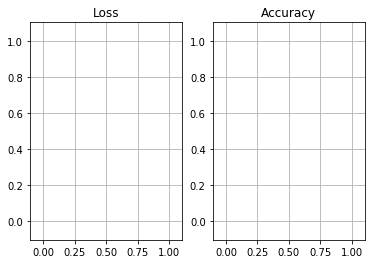

In [15]:
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.plot(testing_loss)
plt.grid(True)
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.grid(True)
plt.title("Accuracy")

In [16]:
kcn.eval()
random_sample = test_img[np.random.choice(range(test_img.shape[0]), 2)]

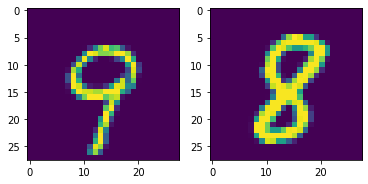

In [17]:
plt.subplot(1,2,1)
plt.imshow(random_sample[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(random_sample[1].reshape(28,28))

In [19]:
rnd = torch.from_numpy(random_sample).type(torch.FloatTensor).cuda()

In [21]:
output = likelihood(kcn(rnd.reshape(2,1,28,28)))
pred = output.probs.mean(0).argmax(-1)            

In [22]:
pred

tensor([9, 8], device='cuda:0')

In [27]:
_,rec,_,cl = cn(rnd.reshape(2,1,28,28))

In [29]:
rec = rec.cpu().data.numpy()

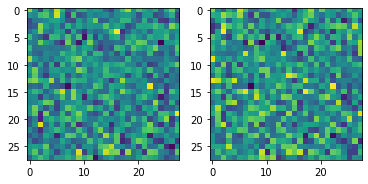

In [30]:
plt.subplot(1,2,1)
plt.imshow(rec[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(rec[1].reshape(28,28))